In [50]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotx
import pandas as pd
from fastcore.xtras import load_pickle
from scipy.stats import sem
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

from gptchem.data import get_hea_phase_data
from gptchem.evaluator import (
    evaluate_classification,
    find_learning_curve_intersection,
    fit_learning_curve,
    lc,
)
from gptchem.formatter import ClassificationFormatter
from gptchem.plotsettings import *
from gptchem.settings import ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH

%matplotlib inline

## N-GRAM

In [52]:
n_gram_baseline = glob("ngram_baseline/*.pkl")
n_gram_baseline_results = []

for f in n_gram_baseline:
    n_gram_baseline_results.append(load_pickle(f))

n_gram_baseline_results = pd.DataFrame(n_gram_baseline_results)

n_gram_baseline_results_grouped = (
    n_gram_baseline_results[
        ["representation", "train_size", "accuracy", "f1_micro", "f1_macro", "kappa"]
    ]
    .groupby(["train_size"])
    .agg(["mean", "std", sem])
)

/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ipykernel_64037/3488370652.py:10: FutureWarning: ['representation'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  n_gram_baseline_results[


In [53]:
n_gram_baseline_results_grouped

accuracy                     f1_micro                      \
               mean       std       sem     mean       std       sem   
train_size                                                             
10           0.6668  0.059451  0.018800   0.6668  0.059451  0.018800   
20           0.7384  0.037580  0.011884   0.7384  0.037580  0.011884   
50           0.8304  0.023566  0.007452   0.8304  0.023566  0.007452   
100          0.8876  0.017933  0.005671   0.8876  0.017933  0.005671   
200          0.9200  0.010499  0.003320   0.9200  0.010499  0.003320   

            f1_macro                       kappa                      
                mean       std       sem    mean       std       sem  
train_size                                                            
10          0.629347  0.074040  0.023413  0.3336  0.118902  0.037600  
20          0.723147  0.044402  0.014041  0.4768  0.075160  0.023768  
50          0.827618  0.024438  0.007728  0.6608  0.047133  0.014905  
100         0.886703  0.018263  0.005775  0.7752  0.035866  0.011342  
200         0.919733  0.010577  0.003345  0.8400  0.020997  0.006640

In [54]:
n_gram_augmented = glob("ngram_augmented/*.pkl")
n_gram_augmented_results = []

for f in n_gram_augmented:
    n_gram_augmented_results.append(load_pickle(f))

n_gram_augmented_results = pd.DataFrame(n_gram_augmented_results)

n_gram_augmented_results_grouped = (
    n_gram_augmented_results[
        ["train_size", "accuracy", "f1_micro", "f1_macro", "kappa"]
    ]
    .groupby(["train_size"])
    .agg(["mean", "std", sem])
)

/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(

## Get the dummy metrics

In [55]:
data = get_hea_phase_data()

In [56]:
estimators = ["uniform", "stratified", "most_frequent"]
results = []
train_sizes = [10, 20, 50, 100, 200]
for i in range(10):
    for estimator in estimators:
        for train_size in train_sizes:
            train, test = train_test_split(
                data,
                train_size=train_size,
                test_size=250,
                stratify=data["phase_binary_encoded"],
                random_state=i,
            )
            classifier = DummyClassifier(strategy=estimator)
            classifier.fit(train["Alloy"], train["phase_binary_encoded"])
            predictions = classifier.predict(test["Alloy"])
            res = evaluate_classification(test["phase_binary_encoded"], predictions)
            res["train_size"] = train_size
            res["estimator"] = estimator
            results.append(res)

In [57]:
dummy_results = pd.DataFrame(results)

In [58]:
dummy_grouped = (
    dummy_results[["train_size", "estimator", "accuracy", "f1_macro", "f1_micro", "kappa"]]
    .groupby(["estimator", "train_size"])
    .agg(["mean", "std", sem])
)

In [59]:
dummy_grouped

accuracy                      f1_macro            \
                             mean       std       sem      mean       std   
estimator     train_size                                                    
most_frequent 10           0.5000  0.000000  0.000000  0.333333  0.000000   
              20           0.5000  0.000000  0.000000  0.333333  0.000000   
              50           0.5000  0.000000  0.000000  0.333333  0.000000   
              100          0.5000  0.000000  0.000000  0.333333  0.000000   
              200          0.5000  0.000000  0.000000  0.333333  0.000000   
stratified    10           0.5060  0.034577  0.010934  0.505616  0.034494   
              20           0.5020  0.029590  0.009357  0.501507  0.029771   
              50           0.4948  0.023855  0.007544  0.494592  0.023947   
              100          0.5056  0.037533  0.011869  0.504805  0.038096   
              200          0.5004  0.036731  0.011615  0.499868  0.036821   
uniform       10           0.5212  0.035229  0.011140  0.521009  0.035306   
              20           0.4800  0.022470  0.007106  0.479750  0.022580   
              50           0.4916  0.023282  0.007362  0.491153  0.023140   
              100          0.5040  0.021333  0.006746  0.503605  0.021373   
              200          0.4964  0.025330  0.008010  0.496055  0.025040   

                                       f1_micro                       kappa  \
                                   sem     mean       std       sem    mean   
estimator     train_size                                                      
most_frequent 10          1.850372e-17   0.5000  0.000000  0.000000  0.0000   
              20          1.850372e-17   0.5000  0.000000  0.000000  0.0000   
              50          1.850372e-17   0.5000  0.000000  0.000000  0.0000   
              100         1.850372e-17   0.5000  0.000000  0.000000  0.0000   
              200         1.850372e-17   0.5000  0.000000  0.000000  0.0000   
stratified    10          1.090785e-02   0.5060  0.034577  0.010934  0.0120   
              20          9.414393e-03   0.5020  0.029590  0.009357  0.0040   
              50          7.572773e-03   0.4948  0.023855  0.007544 -0.0104   
              100         1.204693e-02   0.5056  0.037533  0.011869  0.0112   
              200         1.164392e-02   0.5004  0.036731  0.011615  0.0008   
uniform       10          1.116488e-02   0.5212  0.035229  0.011140  0.0424   
              20          7.140353e-03   0.4800  0.022470  0.007106 -0.0400   
              50          7.317660e-03   0.4916  0.023282  0.007362 -0.0168   
              100         6.758729e-03   0.5040  0.021333  0.006746  0.0080   
              200         7.918463e-03   0.4964  0.025330  0.008010 -0.0072   

                                              
                               std       sem  
estimator     train_size                      
most_frequent 10          0.000000  0.000000  
              20          0.000000  0.000000  
              50          0.000000  0.000000  
              100         0.000000  0.000000  
              200         0.000000  0.000000  
stratified    10          0.069154  0.021868  
              20          0.059180  0.018714  
              50          0.047710  0.015087  
              100         0.075066  0.023738  
              200         0.073462  0.023231  
uniform       10          0.070458  0.022281  
              20          0.044939  0.014211  
              50          0.046564  0.014725  
              100         0.042667  0.013492  
              200         0.050660  0.016020

## Load the results

### CrabNet

In [60]:
crabnet = glob("out-crabnet/*.pkl")

In [61]:
len(crabnet)

50

In [62]:
extracted_crabnet_res = []

for out in crabnet:
    out = load_pickle(out)
    res = {
        "train_size": out["train_size"],
        "frac_valid": out["frac_valid"],
        "accuracy": out["accuracy"],
        "f1_macro": out["f1_macro"],
        "f1_micro": out["f1_micro"],
        "kappa": out["kappa"],
    }

    extracted_crabnet_res.append(res)

In [63]:
extracted_crabnet_res = pd.DataFrame(extracted_crabnet_res)

In [64]:
extracted_crabnet_res_grouped = extracted_crabnet_res.groupby("train_size").agg(
    ["mean", "std", sem]
)

### Automatminer

In [65]:
automatminer_out = glob("out-baseline/**/*.pkl")

In [66]:
extracted_automatminer_res = []

for out in automatminer_out:
    out = load_pickle(out)
    res = {
        "train_size": out["train_size"],
        "frac_valid": out["frac_valid"],
        "accuracy": out["accuracy"],
        "f1_macro": out["f1_macro"],
        "f1_micro": out["f1_micro"],
        "kappa": out["kappa"],
    }

    extracted_automatminer_res.append(res)

In [67]:
extracted_automatminer_res = pd.DataFrame(extracted_automatminer_res)

In [68]:
extracted_automatminer_res_grouped = extracted_automatminer_res.groupby("train_size").agg(
    ["mean", "std", sem]
)

### GPT

In [69]:
all_out = glob("out/**/*.pkl")

In [70]:
all_out = [load_pickle(p) for p in all_out]

In [71]:
extracted_res = []

for out in all_out:
    res = {
        "base_model": out["base_model"],
        "train_size": out["train_size"],
        "test_size": out["test_size"],
        "n_epochs": out["n_epochs"],
        "learning_rate_multiplier": out["learning_rate_multiplier"],
        "frac_valid": out["frac_valid"],
        "accuracy": out["accuracy"],
        "f1_macro": out["f1_macro"],
        "f1_micro": out["f1_micro"],
        "kappa": out["kappa"],
    }

    extracted_res.append(res)

In [72]:
extracted_res = pd.DataFrame(extracted_res)

In [73]:
extracted_res_grouped = extracted_res.groupby(["train_size"]).agg(["mean", "std", sem])

/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ipykernel_64037/403812428.py:1: FutureWarning: ['base_model'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  extracted_res_grouped = extracted_res.groupby(["train_size"]).agg(["mean", "std", sem])


In [74]:
extracted_res_grouped["accuracy"]

,mean,std,sem
train_size,,,
10,0.885600,0.045848,0.014498
20,0.891600,0.054600,0.017266
50,0.932400,0.033224,0.010506
100,0.960444,0.015930,0.005310
200,0.964400,0.008527,0.002696


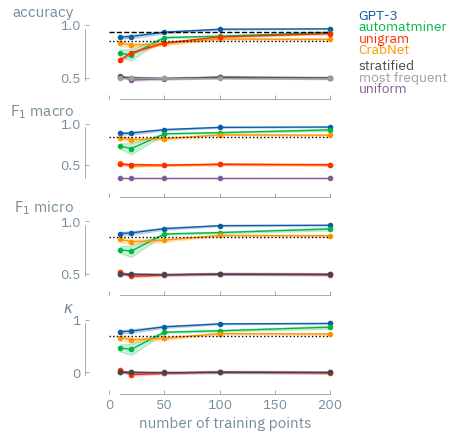

In [79]:
fig, ax = plt.subplots(
    4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH), sharex="all"
)

# accuracy
ax[0].plot(
    extracted_res_grouped.index,
    extracted_res_grouped["accuracy"]["mean"],
    marker="o",
    label="GPT-3",
)
ax[0].fill_between(
    extracted_res_grouped.index,
    extracted_res_grouped["accuracy"]["mean"] - extracted_res_grouped["accuracy"]["sem"],
    extracted_res_grouped["accuracy"]["mean"] + extracted_res_grouped["accuracy"]["sem"],
    alpha=0.2,
    color="C0",
)

ax[0].plot(
    extracted_automatminer_res_grouped.index,
    extracted_automatminer_res_grouped["accuracy"]["mean"],
    marker="o",
    label="automatminer",
)

ax[0].fill_between(
    extracted_automatminer_res_grouped.index,
    extracted_automatminer_res_grouped["accuracy"]["mean"]
    - extracted_automatminer_res_grouped["accuracy"]["sem"],
    extracted_automatminer_res_grouped["accuracy"]["mean"]
    + extracted_automatminer_res_grouped["accuracy"]["sem"],
    alpha=0.2,
    color="C1",
)


ax[0].plot(
    extracted_crabnet_res_grouped.index,
    extracted_crabnet_res_grouped["accuracy"]["mean"],
    marker="o",
    label="CrabNet",
)

ax[0].fill_between(
    extracted_crabnet_res_grouped.index,
    extracted_crabnet_res_grouped["accuracy"]["mean"]
    - extracted_crabnet_res_grouped["accuracy"]["sem"],
    extracted_crabnet_res_grouped["accuracy"]["mean"]
    + extracted_crabnet_res_grouped["accuracy"]["sem"],
    alpha=0.2,
    color="C2",
)

ax[0].plot(
    n_gram_baseline_results_grouped.index,
    n_gram_baseline_results_grouped["accuracy"]["mean"],
    marker="o",
    label="unigram",
)

ax[0].fill_between(
    n_gram_baseline_results_grouped.index,
    n_gram_baseline_results_grouped["accuracy"]["mean"]
    - n_gram_baseline_results_grouped["accuracy"]["sem"],
    n_gram_baseline_results_grouped["accuracy"]["mean"]
    + n_gram_baseline_results_grouped["accuracy"]["sem"],
    alpha=0.2,
    color="C3",
)

# add the dummy models
for i, estimator in enumerate(estimators):
    ax[0].plot(
        dummy_grouped.loc[estimator, :]["accuracy"]["mean"].index,
        dummy_grouped.loc[estimator, :]["accuracy"]["mean"],
        label=estimator.replace("_", " "),
        marker="o",
        color=f"C{i+4}",
    )
    ax[0].fill_between(
        dummy_grouped.loc[estimator, :]["accuracy"]["mean"].index,
        dummy_grouped.loc[estimator, :]["accuracy"]["mean"]
        - dummy_grouped.loc[estimator, :]["accuracy"]["sem"],
        dummy_grouped.loc[estimator, :]["accuracy"]["mean"]
        + dummy_grouped.loc[estimator, :]["accuracy"]["sem"],
        alpha=0.2,
        color=f"C{i+4}",
    )


range_frame(
    ax[0],
    extracted_res_grouped.index,
    np.stack(
        [extracted_res_grouped["accuracy"]["mean"]]
        + [dummy_grouped.loc[estimator, :]["accuracy"]["mean"] for estimator in estimators]
    ).flatten(),
)


# f1 macro
ax[1].plot(
    extracted_res_grouped.index,
    extracted_res_grouped["f1_macro"]["mean"],
    label="GPT-3",
    marker="o",
)
ax[1].fill_between(
    extracted_res_grouped.index,
    extracted_res_grouped["f1_macro"]["mean"] - extracted_res_grouped["f1_macro"]["sem"],
    extracted_res_grouped["f1_macro"]["mean"] + extracted_res_grouped["f1_macro"]["sem"],
    alpha=0.2,
    color="C0",
)

ax[1].plot(
    extracted_automatminer_res_grouped.index,
    extracted_automatminer_res_grouped["f1_macro"]["mean"],
    label="automatminer",
    marker="o",
)
ax[1].fill_between(
    extracted_automatminer_res_grouped.index,
    extracted_automatminer_res_grouped["f1_macro"]["mean"]
    - extracted_automatminer_res_grouped["f1_macro"]["sem"],
    extracted_automatminer_res_grouped["f1_macro"]["mean"]
    + extracted_automatminer_res_grouped["f1_macro"]["sem"],
    alpha=0.2,
    color="C1",
)

ax[1].plot(
    extracted_crabnet_res_grouped.index,
    extracted_crabnet_res_grouped["f1_macro"]["mean"],
    marker="o",
    label="CrabNet",
)

ax[1].fill_between(
    extracted_crabnet_res_grouped.index,
    extracted_crabnet_res_grouped["f1_macro"]["mean"]
    - extracted_crabnet_res_grouped["f1_macro"]["sem"],
    extracted_crabnet_res_grouped["f1_macro"]["mean"]
    + extracted_crabnet_res_grouped["f1_macro"]["sem"],
    alpha=0.2,
    color="C2",
)

# add the dummy models
for i, estimator in enumerate(estimators):
    ax[1].plot(
        dummy_grouped.loc[estimator, :]["f1_macro"]["mean"].index,
        dummy_grouped.loc[estimator, :]["f1_macro"]["mean"],
        label=estimator.replace("_", " "),
        marker="o",
        color=f"C{i+2}",
    )
    ax[1].fill_between(
        dummy_grouped.loc[estimator, :]["f1_macro"]["mean"].index,
        dummy_grouped.loc[estimator, :]["f1_macro"]["mean"]
        - dummy_grouped.loc[estimator, :]["f1_macro"]["sem"],
        dummy_grouped.loc[estimator, :]["f1_macro"]["mean"]
        + dummy_grouped.loc[estimator, :]["f1_macro"]["sem"],
        alpha=0.2,
        color=f"C{i+2}",
    )


range_frame(
    ax[1],
    extracted_res_grouped.index,
    np.stack(
        [extracted_res_grouped["f1_macro"]["mean"]]
        + [dummy_grouped.loc[estimator, :]["f1_macro"]["mean"] for estimator in estimators]
    ).flatten(),
)

# f1 micro

ax[2].plot(
    extracted_res_grouped.index,
    extracted_res_grouped["f1_micro"]["mean"],
    label="GPT-3",
    marker="o",
)
ax[2].fill_between(
    extracted_res_grouped.index,
    extracted_res_grouped["f1_micro"]["mean"] - extracted_res_grouped["f1_micro"]["sem"],
    extracted_res_grouped["f1_micro"]["mean"] + extracted_res_grouped["f1_micro"]["sem"],
    alpha=0.2,
    color="C0",
)

ax[2].plot(
    extracted_automatminer_res_grouped.index,
    extracted_automatminer_res_grouped["f1_micro"]["mean"],
    label="automatminer",
    marker="o",
)
ax[2].fill_between(
    extracted_automatminer_res_grouped.index,
    extracted_automatminer_res_grouped["f1_micro"]["mean"]
    - extracted_automatminer_res_grouped["f1_micro"]["sem"],
    extracted_automatminer_res_grouped["f1_micro"]["mean"]
    + extracted_automatminer_res_grouped["f1_micro"]["sem"],
    alpha=0.2,
    color="C1",
)

ax[2].plot(
    extracted_crabnet_res_grouped.index,
    extracted_crabnet_res_grouped["f1_micro"]["mean"],
    marker="o",
    label="CrabNet",
)

ax[2].fill_between(
    extracted_crabnet_res_grouped.index,
    extracted_crabnet_res_grouped["f1_micro"]["mean"]
    - extracted_crabnet_res_grouped["f1_micro"]["sem"],
    extracted_crabnet_res_grouped["f1_micro"]["mean"]
    + extracted_crabnet_res_grouped["f1_micro"]["sem"],
    alpha=0.2,
    color="C2",
)

# add the dummy models
for i, estimator in enumerate(estimators):
    ax[2].plot(
        dummy_grouped.loc[estimator, :]["f1_micro"]["mean"].index,
        dummy_grouped.loc[estimator, :]["f1_micro"]["mean"],
        label=estimator.replace("_", " "),
        marker="o",
        color=f"C{i+3}",
    )
    ax[2].fill_between(
        dummy_grouped.loc[estimator, :]["f1_micro"]["mean"].index,
        dummy_grouped.loc[estimator, :]["f1_micro"]["mean"]
        - dummy_grouped.loc[estimator, :]["f1_micro"]["sem"],
        dummy_grouped.loc[estimator, :]["f1_micro"]["mean"]
        + dummy_grouped.loc[estimator, :]["f1_micro"]["sem"],
        alpha=0.2,
        color=f"C{i+3}",
    )


range_frame(
    ax[2],
    extracted_res_grouped.index,
    np.stack(
        [extracted_res_grouped["f1_micro"]["mean"]]
        + [dummy_grouped.loc[estimator, :]["f1_micro"]["mean"] for estimator in estimators]
    ).flatten(),
)


# kappa
ax[3].plot(
    extracted_res_grouped.index,
    extracted_res_grouped["kappa"]["mean"],
    label="GPT-3",
    marker="o",
)
ax[3].fill_between(
    extracted_res_grouped.index,
    extracted_res_grouped["kappa"]["mean"] - extracted_res_grouped["kappa"]["sem"],
    extracted_res_grouped["kappa"]["mean"] + extracted_res_grouped["kappa"]["sem"],
    alpha=0.2,
    color="C0",
)

ax[3].plot(
    extracted_automatminer_res_grouped.index,
    extracted_automatminer_res_grouped["kappa"]["mean"],
    label="automatminer",
    marker="o",
)
ax[3].fill_between(
    extracted_automatminer_res_grouped.index,
    extracted_automatminer_res_grouped["kappa"]["mean"]
    - extracted_automatminer_res_grouped["kappa"]["sem"],
    extracted_automatminer_res_grouped["kappa"]["mean"]
    + extracted_automatminer_res_grouped["kappa"]["sem"],
    alpha=0.2,
    color="C1",
)

ax[3].plot(
    extracted_crabnet_res_grouped.index,
    extracted_crabnet_res_grouped["kappa"]["mean"],
    marker="o",
    label="CrabNet",
)

ax[3].fill_between(
    extracted_crabnet_res_grouped.index,
    extracted_crabnet_res_grouped["kappa"]["mean"] - extracted_crabnet_res_grouped["kappa"]["sem"],
    extracted_crabnet_res_grouped["kappa"]["mean"] + extracted_crabnet_res_grouped["kappa"]["sem"],
    alpha=0.2,
    color="C2",
)


# add the dummy models
for i, estimator in enumerate(estimators):
    ax[3].plot(
        dummy_grouped.loc[estimator, :]["kappa"]["mean"].index,
        dummy_grouped.loc[estimator, :]["kappa"]["mean"],
        label=estimator.replace("_", " "),
        marker="o",
        color=f"C{i+3}",
    )
    ax[3].fill_between(
        dummy_grouped.loc[estimator, :]["kappa"]["mean"].index,
        dummy_grouped.loc[estimator, :]["kappa"]["mean"]
        - dummy_grouped.loc[estimator, :]["kappa"]["sem"],
        dummy_grouped.loc[estimator, :]["kappa"]["mean"]
        + dummy_grouped.loc[estimator, :]["kappa"]["sem"],
        alpha=0.2,
        color=f"C{i+3}",
    )


range_frame(
    ax[3],
    extracted_res_grouped.index,
    np.stack(
        [extracted_res_grouped["kappa"]["mean"]]
        + [dummy_grouped.loc[estimator, :]["kappa"]["mean"] for estimator in estimators]
    ).flatten(),
)


ax[0].hlines(0.93, 0, 200, color="k", linestyle="--")

ax[0].hlines(0.848800, 0, 200, color="k", linestyle="dotted")
ax[1].hlines(0.847319, 0, 200, color="k", linestyle="dotted")
ax[2].hlines(0.848800, 0, 200, color="k", linestyle="dotted")
ax[3].hlines(0.697600, 0, 200, color="k", linestyle="dotted")

ylabel_top("accuracy", ax=ax[0], x_pad=0.08, y_pad=-0.01)
ylabel_top(r"F$_{1}$ macro", ax=ax[1], x_pad=0.08, y_pad=-0.05)
ylabel_top(r"F$_{1}$ micro", ax=ax[2], x_pad=0.08, y_pad=-0.03)
ylabel_top(r"$\kappa$", ax=ax[3], x_pad=0.08, y_pad=-0.04)
ax[-1].set_xlabel("number of training points", labelpad=4)
matplotx.line_labels(ax[0])
plt.subplots_adjust(hspace=0.6, top=1, bottom=0.2)
fig.savefig("hea_single_vs_multiphase_classifier.pdf", bbox_inches="tight")

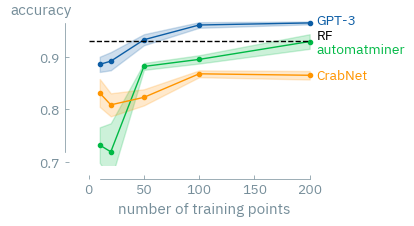

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(ONE_COL_WIDTH_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH))

ax.plot(
    extracted_res_grouped.index,
    extracted_res_grouped["accuracy"]["mean"],
    label="GPT-3",  
    marker="o",
)
ax.fill_between(
    extracted_res_grouped.index,
    extracted_res_grouped["accuracy"]["mean"] - extracted_res_grouped["accuracy"]["sem"],
    extracted_res_grouped["accuracy"]["mean"] + extracted_res_grouped["accuracy"]["sem"],
    alpha=0.2,
    color="C0",
)

ax.plot(
    extracted_automatminer_res_grouped.index,
    extracted_automatminer_res_grouped["accuracy"]["mean"],
    label="automatminer",
    marker="o",
    c="C1",
)
ax.fill_between(
    extracted_automatminer_res_grouped.index,
    extracted_automatminer_res_grouped["accuracy"]["mean"]
    - extracted_automatminer_res_grouped["accuracy"]["sem"],
    extracted_automatminer_res_grouped["accuracy"]["mean"]
    + extracted_automatminer_res_grouped["accuracy"]["sem"],
    alpha=0.2,
    color="C1",
)

ax.plot(
    extracted_crabnet_res_grouped.index,
    extracted_crabnet_res_grouped["accuracy"]["mean"],
    marker="o",
    label="CrabNet",
    c="C2",
)
ax.fill_between(
    extracted_crabnet_res_grouped.index,
    extracted_crabnet_res_grouped["accuracy"]["mean"] - extracted_crabnet_res_grouped["accuracy"]["sem"],
    extracted_crabnet_res_grouped["accuracy"]["mean"] + extracted_crabnet_res_grouped["accuracy"]["sem"],
    alpha=0.2,
    color="C2",
)


# add plot for this value
ax.plot(
    [0, 200],
    [0.93, 0.93],
     color="k", linestyle="--",
     label='RF'
)

matplotx.line_labels(ax)

ax.set_xlabel("number of training points", labelpad=4)
ylabel_top("accuracy", ax=ax, x_pad=0.01, y_pad=0.08)

range_frame(
    ax,
    extracted_res_grouped.index,
    np.stack(
        [extracted_res_grouped["accuracy"]["mean"].values.flatten(), 
            extracted_automatminer_res_grouped["accuracy"]["mean"].values.flatten(),
            extracted_crabnet_res_grouped["accuracy"]["mean"].values.flatten()]
    ).flatten(),
)

fig.savefig('accuracy_slide_figure.pdf', bbox_inches='tight')

In [77]:
find_learning_curve_intersection(
    extracted_res_grouped["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        extracted_automatminer_res_grouped.index,
        extracted_automatminer_res_grouped["f1_macro"]["mean"],
    )[0],
) / 10

/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/src/gptchem/evaluator.py:582: RuntimeWarning: overflow encountered in exp
  return -a * np.exp(-b * x) + c
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


24.14375077364608

In [78]:
find_learning_curve_intersection(
    extracted_res_grouped["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        extracted_crabnet_res_grouped.index,
        extracted_crabnet_res_grouped["f1_macro"]["mean"],
    )[0],
) / 10

9.02343136381952

In [ ]:
dummy_grouped

In [ ]:
dummy_grouped.loc["most_frequent"]

In [ ]:
input_frame = pd.read_json(
    "/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/03_classification/hea_single_vs_multiphase/out/20230109_155453/train.jsonl",
    lines=True,
)

In [32]:
input_frame

,prompt,completion,label,representation
0,What is the phase of Co1Cu1Fe1Ni1V1?###,0@@@,0,Co1Cu1Fe1Ni1V1
1,What is the phase of Pu0.75Zr0.25?###,1@@@,1,Pu0.75Zr0.25
2,What is the phase of BeFe?###,0@@@,0,BeFe
3,What is the phase of LiTa?###,0@@@,0,LiTa
4,What is the phase of Nb0.5Ta0.5?###,1@@@,1,Nb0.5Ta0.5
5,What is the phase of Al0.1W0.9?###,1@@@,1,Al0.1W0.9
6,What is the phase of Cr0.5Fe0.5?###,1@@@,1,Cr0.5Fe0.5
7,What is the phase of Al1Co1Cr1Cu1Fe1Ni1Ti1?###,0@@@,0,Al1Co1Cr1Cu1Fe1Ni1Ti1
8,What is the phase of Cu0.5Mn0.5?###,1@@@,1,Cu0.5Mn0.5
9,What is the phase of OsU?###,0@@@,0,OsU


In [33]:
for i, row in input_frame.iterrows():
    print(row["prompt"] + " & " + str(row["label"]) + " \\\\")

What is the phase of Co1Cu1Fe1Ni1V1?### & 0 \\
What is the phase of Pu0.75Zr0.25?### & 1 \\
What is the phase of BeFe?### & 0 \\
What is the phase of LiTa?### & 0 \\
What is the phase of Nb0.5Ta0.5?### & 1 \\
What is the phase of Al0.1W0.9?### & 1 \\
What is the phase of Cr0.5Fe0.5?### & 1 \\
What is the phase of Al1Co1Cr1Cu1Fe1Ni1Ti1?### & 0 \\
What is the phase of Cu0.5Mn0.5?### & 1 \\
What is the phase of OsU?### & 0 \\


## Plot N-gram augmented results

Text(0.5, 0, 'number of training points')

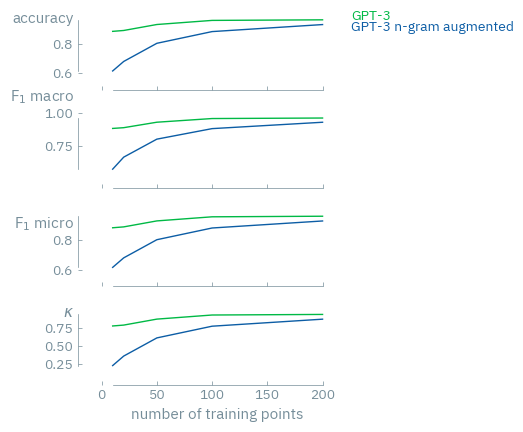

In [84]:
fig, ax = plt.subplots(
    4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH), sharex="all"
)

for i, metric in enumerate(['accuracy', 'f1_macro', 'f1_micro', 'kappa']):
    ax[i].plot(
        n_gram_augmented_results_grouped.index,
        n_gram_augmented_results_grouped[metric]["mean"],
        label="GPT-3 n-gram augmented",
    )

    ax[i].plot(
        extracted_res_grouped.index,
        extracted_res_grouped[metric]["mean"],
        label="GPT-3",
    )

    range_frame(
        ax=ax[i],
        x=n_gram_augmented_results_grouped.index,
        y=np.stack(
            [
                n_gram_augmented_results_grouped[metric]["mean"],
                extracted_res_grouped[metric]["mean"],
            ]
        ).flatten(),
    )

matplotx.line_labels(ax[0])

ylabel_top("accuracy", ax=ax[0],  y_pad=0.2, x_pad=0.05)
ylabel_top(r"F$_{1}$ macro", ax=ax[1], x_pad=0.05)
ylabel_top(r"F$_{1}$ micro", ax=ax[2],x_pad=0.05)
ylabel_top(r"$\kappa$", ax=ax[3], x_pad=0.05)
plt.subplots_adjust(hspace=0.6, top=1, bottom=0.2)

ax[-1].set_xlabel("number of training points", labelpad=4)